# HSE 2021: Mathematical Methods for Data Analysis

# Seminar 12. Bayesian Linear Regression and Relevance Vector Machine (Regression Implementation) Tutorial

**Authors**: Evgenii Egorov, Maksim Karpov

## Outline

- [Bayesian Linear Regression](#blr)

- [Relevance Vector Machine (Regression Implementation)](#rvm)

## Bayesian Linear Regression Recap <a id="blr"></a>

This notebook follows the [Bishop](https://www.amazon.com/Pattern-Recognition-Learning-Information-Statistics/dp/0387310738/ref=sr_1_1?ie=UTF8&qid=1474908936&sr=8-1&keywords=pattern+recognition+and+machine+learning) treatment of the Bayesian approach to linear regression. A python tutorial for a Bayesian treatment of Linear Regression: https://zjost.github.io/bayesian-linear-regression/

## The Target
Assume the target $t$ is given by some function of the inputs/parameters plus a noise term.

$$t = f(\vec{x}, \vec{w}) + \epsilon $$

Let's assume the noise is characterized by a normal distribution of mean 0 and precision $\beta$.  Therefore we can say the probability of a value $t$ is given by a normal distribution around the value of the function $f(\vec{x}, \vec{w})$ at that point:

$$p(t \mid \vec{x}, \vec{w}) = Norm(t \mid f(\vec{x}, \vec{w}), \beta^{-1}) \tag{1}$$ 

where $Norm(t \mid \mu, \sigma^2)$ represents a normal distribution of mean $\mu$ and variance $\sigma^2$.

Ultimately, we want to be able to predict $t$ for a new input $\vec{x}$ given some old data $D$ to base that prediction on: 

$$p(t \mid \vec{x}, D)$$

Our Bayesian treatment will allow us to assign this **probability to each value of $t$** for a given $\vec{x}$.  Note that this is more powerful than merely assigning a single-valued estimate of $t$ like traditional Linear Regression, because the probability distribution allows us to assess our *uncertainty in our estimate*, or "model uncertainty".  If we need an estimate for $t$ we can simply choose the maximum of this probability distribution.

### The Model
Let's assume a model for this target that's linear in the parameters $\{w_j\}$, but has a general basis representation of the inputs given by $\{\phi_j(\vec{x})\}$.  This results in the following model form:
$$y(\vec{x}, \vec{w}) = w_0 + \sum_{j=1}^{M-1} w_j\phi_j(\vec{x})$$ 
where M is the total number of model parameters.

Note that the basis functions $\phi_j(\vec{x})$ do *not* need to be linear in $\vec{x}$; the linearity required in the assumptions is in reference to the parameters $\{w_j\}$.  We could therefore have, e.g. $\phi_n(x) = sin(nx)$.

For convenience, let's define the basis function $\phi_0(\vec{x}) \equiv 1$ so that we can write the model as a vector equation: 

$$y(\vec{x}, \vec{w}) = \vec{w}^T \vec{\phi}(\vec{x})$$

where $\vec{\phi} = (\phi_0, ..., \phi_{M-1})^T$ and $\vec{w} = (w_0, ..., w_{M-1})^T$

Therefore our model of the target $t$ is given by:

$$p(t \mid \vec{x}, \vec{w}) =  Norm(t \mid y(\vec{x}, \vec{w}), \beta^{-1}) = Norm(t \mid \vec{w}^T \vec{\phi}(\vec{x}), \beta^{-1}) \tag{2}$$ 

and we hope, among other things, to find values for $\vec{w}$ that make a good fit to the true model, given by $(1)$.

## Strategy
Recall our true goal is a predictive distribution for $t$ given a new $\vec{x}$ that's based on data $D$:

$$p(t \mid \vec{x}, D)$$

We can use the marginalization rule $p(x) = \int p(x, y) dy$ to integrate over our parameter values $\vec{w}$:

$$p(t \mid \vec{x}, D) = \int p(t, \vec{w} \mid \vec{x}, D) d\vec{w} $$

An application of the product rule to this integral gives:

$$p(t \mid \vec{x}, D) = \int p(t \mid \vec{x}, \vec{w})p(\vec{w} \mid D) d\vec{w} \tag{3}$$

This result is an integral of two terms:  a) our model given by $(2)$, which uses a particular set of parameter values, and b) a probability for these parameter values.  **In other words, our overall distribution considers every possible parameter value, evaluates a model that has those parameter values and then weights that answer by the probability of us having those parameter values in the first place.**  

Note that this probability distribution of parameters is conditional on the observed data.  We can now use Baye's Theorem to evaluate this conditional probability to take the observational data into account: 

$$p(\vec{w} \mid D) = \frac{p(\vec{w})p(D \mid \vec{w})}{p(D)} = \frac{p(\vec{w})\mathcal{L}(\vec{w} \mid D)}{p(D)}$$  

where $\mathcal{L}(\vec{w} \mid D) = p(D \mid \vec{w})$ is the likelihood of paramters $\vec{w}$ given observational data $D$.  Let's now use vector $\vec{t}$ to represent our data for the target $t$.

The likelihood of a given parameter vector $\vec{w}$ given independent, identically distributed points is calculated by a product of the individual probabilities, which are given by our model in $(2)$:
$$\mathcal{L}(\vec{w} \mid \vec{t}) = p(\vec{t} \mid \vec{X}, \vec{w}) = \prod_{n=1}^{N} p(t \mid \vec{x}_n, \vec{w}) = \prod_{n=1}^{N} Norm(t_n \mid \vec{w}^T \vec{\phi}(\vec{x_n}), \beta^{-1}) \tag{4}$$
where $\vec{t}$ is a vector of $N$ target values, $\vec{X}$ is an $N \times (M-1)$ matrix of feature vectors and $\vec{x_n}$ is the feature vector for the n-th datum.

We will construct a **conjugate prior** such that when we multiply the likelihood by this prior $p(\vec{w})$, we get a function of the same form as the prior.  This will result in **simple update equations** for the parameters of the conjugate prior that convert it into the posterior distribution.  This allows us to sequentially update our estimation as new data comes in.

This strategy has the practical advantage of us not needing to calculate the normalizing denominator of Bayes' Theorem $p(D)$ since our conjugate prior will have a form that's easy to normalize.

## Example Case:  Known Noise Precision
### Theory
First, let's assume we know the precision of the gaussian noise $\beta$ from $(1)$ in advance.  In this case our conjugate prior for the weight parameters turns out to be a simple normal distribution:

$$p(\vec{w}) = Norm(\vec{w} \mid \vec{m}_0, \vec{S}_0) \tag{5}$$

where $\vec{m}_0$ is our prior estimation for the mean value and $\vec{S}_0$ is our prior estimation of the covariance of our distribution.  The conjugate prior is a normal distribution because when you multiply the likelihood by a normal distribution, you can complete the square to get another normal distribution.  The trick is to find how the multiplication of the likelihood changes the parameters of this normal distribution.

Writing it out, the posterior distribution for our weight parameters once we observe the data is then equal to the likelihood $(4)$ multiplied by our prior $(5)$, all adjusted by some normalization constant $Z$:
$$p(\vec{w} \mid \vec{t}, \vec{X}) = \frac{1}{Z} \times p(\vec{t} \mid \vec{X}, \vec{w}) \times p(\vec{w}) = \frac{1}{Z} \prod_{n=1}^{N} Norm(t_n \mid \vec{w}^T \vec{\phi}(\vec{x_n}), \beta^{-1}) \times Norm(\vec{w} \mid \vec{m}_0, \vec{S}_0)$$

The normalization constant can be ignored until the end since the resulting normal distribution can have its normalization constant computed easily.  This results in a normalized form given by:
$$p(\vec{w} \mid \vec{t}) =  Norm(\vec{w} \mid \vec{m}_N, \vec{S}_N) \tag{6.1}$$
where the parameters are updated via these equations:
$$ \vec{S}^{-1}_N = \vec{S}_0^{-1} + \beta\vec{\Phi}^T\vec{\Phi} \tag{6.2}$$
$$ \vec{m}_N = \vec{S}_N(\vec{S}_0^{-1}\vec{m}_0 + \beta\vec{\Phi}^T\vec{t}) \tag{6.3}$$
with 
$$ \vec{\Phi} \equiv   \begin{bmatrix}
    \phi_0(\vec{x}_1)       & \phi_1(\vec{x}_1) & \dots & \phi_{M-1}(\vec{x}_1) \\
    \phi_0(\vec{x}_2)       & \phi_1(\vec{x}_2) & \dots & \phi_{M-1}(\vec{x}_2) \\
    \vdots                  & \vdots            & \ddots & \vdots               \\
    \phi_0(\vec{x}_N)       & \phi_1(\vec{x}_N) & \dots & \phi_{M-1}(\vec{x}_N)
\end{bmatrix}
$$

Note that if data comes in sequentially, the posterior of the previous step becomes the prior of the current step and we only need to calculate the updates to $\vec{m}_N$ and $\vec{S}_N^{-1}$.

### Practice
Let's say the true function (which will be unknown to our analysis) is given by 

$$ f(x, \vec{a}) = a_0 + a_1x + \epsilon \tag{7.1}$$ 

with noise $\epsilon$ given by

$$\epsilon = Norm(n \mid 0, \beta^{-1}) \tag{7.2}$$


where 
$$a_0 = {-0.3} \\
a_1 = 0.5 \\
\beta = \frac{1}{0.2^2}$$

We generate observational data by sampling input $x$ from a uniform distribution $ U(x \mid -1, 1)$, generating noise $\epsilon$ by sampling from $(7.2)$, and then evaluating $(7.1)$ to get our target $t$.  This gives us our dataset $\{\vec{X}, \vec{t}\}$.


For our Bayesian analysis we'll start with a simple prior that has means of zero and assumes the precisions are isotropic and governed by a single precision parameter $\alpha$:
$$ p(\vec{w} \mid \alpha) = Norm(\vec{w} \mid \vec{0}, \alpha^{-1}\vec{I}) \tag{8}$$

Our posterior updates $(6.2, 6.3)$ then evaluate to:
$$ \vec{S}^{-1}_N = \alpha\vec{I} + \beta\vec{\Phi}^T\vec{\Phi} \tag{9.1}$$
$$ \vec{m}_N = \beta\vec{S}_N\vec{\Phi}^T\vec{t} \tag{9.2}$$

Recall that in this case, we're assuming that the noise precision of $\beta$ is known to us.

In sum, we'll be using the data to estimate a probability distribution for the values of $\{w_0, w_1\}$, which is the second term under the integral in $(3)$.  If everything is correct, our probability distribution should converge to values very close to $\{a_0, a_1\}$ even though our prior is starting out centered at $\{0, 0\}$.  

Once we calculate this probability distribution we can plug it into $(3)$ along with our model and integrate to get our ultimate goal:  an equation that predicts the probability of various values of $t$ for a given $x$ based on historical data.

In [1]:
import numpy as np
from numpy.random import normal, uniform
from scipy.stats import multivariate_normal as mv_norm
import matplotlib.pyplot as plt
%matplotlib inline

Here we code up our real function

In [2]:
def real_function(a_0, a_1, noise_sigma, x):
    """
    Evaluates the real function
    """
    N = len(x)
    if noise_sigma==0:
        # Recovers the true function
        return a_0 + a_1*x
    else:
        return a_0 + a_1*x + normal(0, noise_sigma, N)

We now define a class that will perform our parameter updates according to our equations above.  It also handles some useful plotting functionality we'll leverage below.  Note that the only inputs are the prior's mean, covariance and the assumed known noise prediction parameter $\beta$.

In [3]:
class LinearBayes(object):
    """
    A class that holds parameter prior/posterior and handles 
    the hyper-parameter updates with new data
    
    Note:  variables starting with "v_" indicate Nx1 dimensional 
        column vectors, those starting with "m_" indicate 
        matrices, and those starting with "a_" indicate 
        1xN dimensional arrays.
    
    Args:
        a_m0 (np.array): prior mean vector of size 1xM
        m_S0 (np.ndarray): prior covariance matrix of size MxM
        beta (float): known real-data noise precision
        
    """
    def __init__(self, a_m0, m_S0, beta):
        self.prior = mv_norm(mean=a_m0, cov=m_S0)
        self.v_m0 = a_m0.reshape(a_m0.shape + (1,)) #reshape to column vector
        self.m_S0 = m_S0
        self.beta = beta
        
        self.v_mN = self.v_m0
        self.m_SN = self.m_S0
        self.posterior = self.prior
           
    def get_phi(self, a_x):
        """
        Returns the design matrix of size (NxM) for a feature vector v_x.
        In this case, this function merely adds the phi_0 dummy basis
        that's equal to 1 for all elements.
        
        Args:
            a_x (np.array): input features of size 1xN
        """
        m_phi = np.ones((len(a_x), 2))
        m_phi[:, 1] = a_x
        return m_phi
        
    def set_posterior(self, a_x, a_t):
        """
        Updates mN and SN given vectors of x-values and t-values
        """
        # Need to convert v_t from an array into a column vector
        # to correctly compute matrix multiplication
        v_t = a_t.reshape(a_t.shape + (1,))

        m_phi = self.get_phi(a_x)
        
        self.m_SN = np.linalg.inv(np.linalg.inv(self.m_S0) + self.beta*m_phi.T.dot(m_phi))
        self.v_mN = self.m_SN.dot(np.linalg.inv(self.m_S0).dot(self.v_m0) + \
                                      self.beta*m_phi.T.dot(v_t))
        
        self.posterior = mv_norm(mean=self.v_mN.flatten(), cov=self.m_SN)

    
    def prediction_limit(self, a_x, stdevs):
        """
        Calculates the limit that's "stdevs" standard deviations
        away from the mean at a given value of x.
        
        Args:
            a_x (np.array): x-axis values of size 1xN
            stdevs (float): Number of standard deviations away from
                the mean to calculate the prediction limit
        
        Returns:
            np.array: the prediction limit "stdevs" standard deviations
                away from the mean corresponding to x-values in "v_x"
        
        """
        N = len(a_x)
        m_x = self.get_phi(a_x).T.reshape((2, 1, N))
        
        predictions = []
        for idx in range(N):
            x = m_x[:,:,idx]
            sig_sq_x = 1/self.beta + x.T.dot(self.m_SN.dot(x))
            mean_x = self.v_mN.T.dot(x)
            predictions.append((mean_x+stdevs*np.sqrt(sig_sq_x)).flatten())
        return np.concatenate(predictions)
    
    def generate_data(self, a_x):
        N = len(a_x)
        m_x = self.get_phi(a_x).T.reshape((2, 1, N))
        
        predictions = []
        for idx in range(N):
            x = m_x[:,:,idx]
            sig_sq_x = 1/self.beta + x.T.dot(self.m_SN.dot(x))
            mean_x = self.v_mN.T.dot(x)
            predictions.append(normal(mean_x.flatten(), np.sqrt(sig_sq_x)))
        return np.array(predictions)
    
    def make_contour(self, a_x, a_y, real_parms=[], N=0):
        """
        A helper function to generate contour plots of our probability distribution
        """
        pos = np.empty(a_x.shape + (2,))
        pos[:, :, 0] = a_x
        pos[:, :, 1] = a_y

        plt.contourf(a_x, a_y, self.posterior.pdf(pos), 20)
        plt.xlabel('$w_0$', fontsize=16)
        plt.ylabel('$w_1$', fontsize=16)
        
        if real_parms:
            plt.scatter(real_parms[0], real_parms[1], marker='+', c='black', s=60)
            
        _ = plt.title('Distribution for Weight Parameters using %d datapoint(s)' % N, fontsize=10)
    
    def make_scatter(self, a_x, a_t, real_parms, samples=None, stdevs=None):
        """
        A helper function to plot noisey data, the true function, 
        and optionally a set of lines specified by the nested array of
        weights of size NxM where N is number of lines, M is 2 for 
        this simple model
        """
        plt.scatter(a_x, a_t, alpha=0.5)
        plt.xlabel('x')
        plt.ylabel('t')

        plt.plot([-1, 1], real_function(real_parms[0], real_parms[1], 0, np.array([-1., 1.])), 'r')

        _ = plt.title('Real Data from Noisey Linear Function')
        
        if samples:
            weights = self.posterior.rvs(samples)
            for weight in weights: 
                plt.plot([-1, 1], real_function(weight[0], weight[1], 0, np.array([-1., 1.])), 'black')
                _ = plt.title('Lines Sampled from Posterior Distribution vs Real Line and Data')
                
        if stdevs:
            a_xrange = np.linspace(-1, 1, 100)
            y_upper = self.prediction_limit(a_xrange, stdevs)
            y_lower = self.prediction_limit(a_xrange, -stdevs)
            plt.plot(a_xrange, y_upper, '+', c='green', linewidth=4.0)
            plt.plot(a_xrange, y_lower, '+', c='green', linewidth=4.0)
            _ = plt.title('Lines Sampled from Posterior Distribution vs Real Line and Data')

First, let's set our real function parameters for $(7.1)$.  These are what we're trying to recover.  We also set a value for the noise precision $\beta$, which we assume is known to us.  We then generate some noisey data from this true function and noise level.

In [4]:
# Real function parameters
a_0 = -0.3
a_1 = 0.5
noise_sigma = 0.2
beta = 1/noise_sigma**2
# Generate input features from uniform distribution
np.random.seed(20) # Set the seed so we can get reproducible results
x_real = uniform(-1, 1, 1000)
# Evaluate the real function for training example inputs
t_real = real_function(a_0, a_1, noise_sigma, x_real)

Now let's set up our prior distribution.  We need to assign hyper-parameters that represent the prior's mean and covariance.  We said above that we'll assume an isotropic gaussian, which means the covariance will be constant and the same in all directions.  Let's choose a precision of $\alpha = 2.0$.  Our covariance is then the inverse of this value multiplied by the identity matrix.  We then instantiate an instance of our helper `LinearBayes` class defined above.

In [5]:
alpha = 2.0
v_m0 = np.array([0., 0.])
m_S0 = 1/alpha*np.identity(2)

linbayes = LinearBayes(v_m0, m_S0, beta)

Our real, noisey data is shown below as the blue dots.  The "true" function parameters we're trying to find are represented by the red line function.

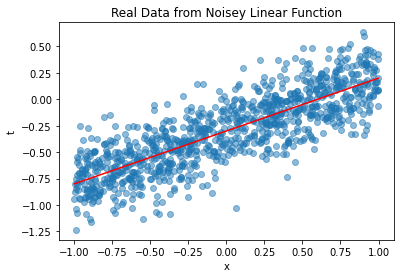

In [6]:
linbayes.make_scatter(x_real, t_real, real_parms = [a_0, a_1])

Let's take a look at the prior distribution.  The real values for the true parameters ($a_0=-0.3, a_1=0.5$) are represented as a black tick mark.  Note that our prior distribution is centered at $(0, 0)$ and assigns relatively low, but non-zero probability to where the true parameter values lie.

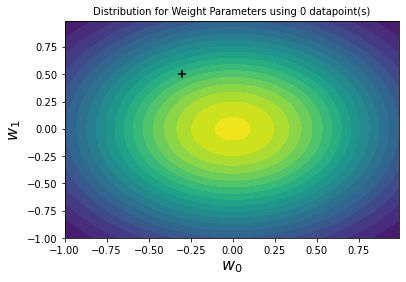

In [7]:
x, y = np.mgrid[-1:1:.01, -1:1:.01]
linbayes.make_contour(x, y, real_parms=[a_0, a_1], N=0)

Let's pull out a single data point from our real data and see how it relates to the true function.

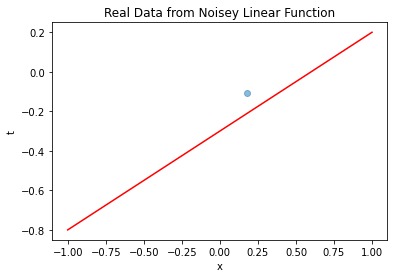

In [8]:
N=1
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1])

Now let's use this data point to update our estimation of the red line.  We'll do this by updating the $ \{\vec{m}_N, \vec{S}_N\}$ parameters according to our formulae above, and plot the posterior distribution for the model parameters.

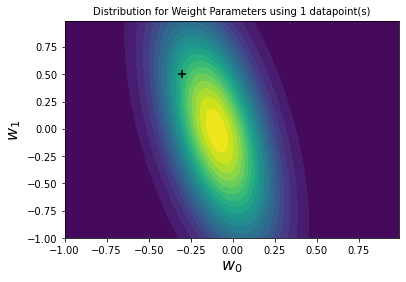

In [9]:
linbayes.set_posterior(x_real[0:N], t_real[0:N])
linbayes.make_contour(x, y, real_parms=[a_0, a_1], N=N)

Let's pull random samples from this distribution to get a collection of $\{w_0, w_1\}$.  These are 5 different estimates for our line.  We'll then plot what those lines look like in comparison to both the true model and our single data point used in the parameter update.

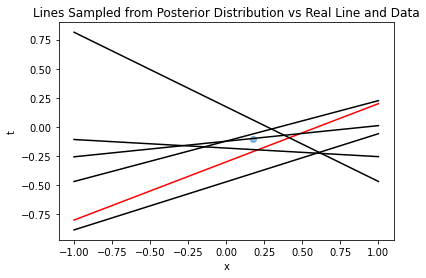

In [10]:
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1], samples=5)

Note that these lines tend to come close to the data point but vary a great deal far from the point.  

But generally, we're not interested in what the values of $\{w_0, w_1\}$ are for their own sake.  We only care about them so that we can make predictions of what $t$ should be given a new $\vec{x}$.  So instead of looking at particular lines by sampling $\{w_0, w_1\}$ from our posterior distribution, let's look at the **predictive distribution** itself by plugging our posterior distribution into $(3)$.

Written with all of our parameters:

$$ p(t \mid \vec{t}, \alpha, \beta) = \int p(t \mid \vec{w}, \beta)p(\vec{w} \mid \vec{t}, \alpha, \beta) d\vec{w}  $$


where $p(t \mid \vec{w}, \beta)$ represents our model $(2)$ for a set of parameters and $p(\vec{w} \mid \vec{t}, \alpha, \beta)$ is our posterior distribution we've been calculating.  This evaluates analytically to be:
$$ p(t \mid \vec{t}, \alpha, \beta) = Norm(t \mid \vec{m}_N^T\vec{\phi}(\vec{x}), \sigma_N^2(\vec{x})) \tag{10.1}$$ where 
$$ \sigma_N^2(\vec{x}) = \frac{1}{\beta} + \vec{\phi}(\vec{x})^T\vec{S}_N\vec{\phi}(\vec{x}) \tag{10.2}$$

This is our ultimate prediction engine we wanted.  First of all, notice that the mean and variance of this normal distribution **depend on $\vec{x}$**.  This means we have a sort of sliding normal distribution that changes it's mean and variance as it goes from left to right.  That's hard to visualize, so let's take a look at the curves that are $\pm \sigma_N$ from its mean.  This represents confidence intervals around our estimate for what $t$ should be at a given value of $x$.

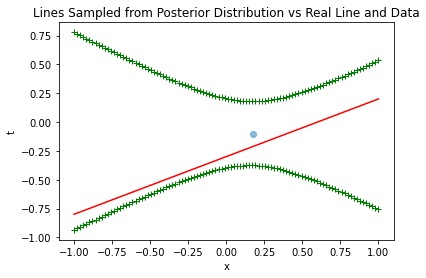

In [11]:
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1], stdevs=1)

Note that these upper/lower bounds are closest together around the one data point we used.

Now let's try adding a second data point.

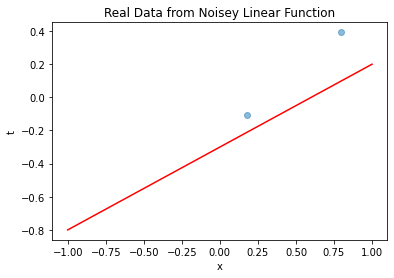

In [12]:
N=2
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1])

Here's the posterior distribution for the weights using both data points.

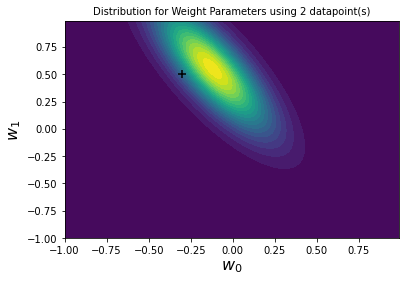

In [13]:
linbayes.set_posterior(x_real[0:N], t_real[0:N])
linbayes.make_contour(x, y, real_parms=[a_0, a_1], N=N)

Let's pull some samples from this distribution to generate some example estimates and include the 1-standard deviation confidence intervals.

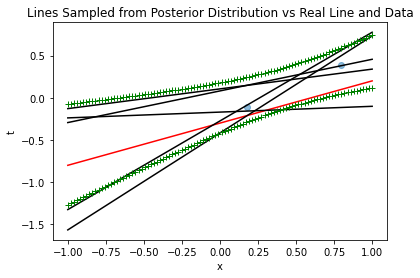

In [14]:
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1], samples=5, stdevs=1)

Now let's use 10 points

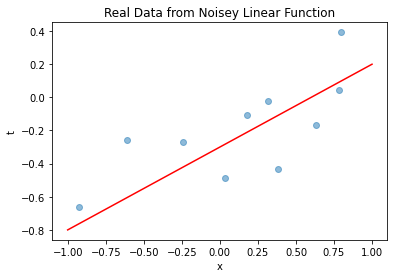

In [15]:
N=10
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1])

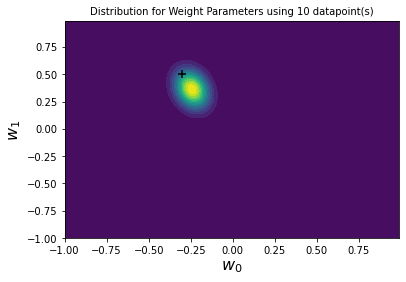

In [16]:
linbayes.set_posterior(x_real[0:N], t_real[0:N])
linbayes.make_contour(x, y, real_parms=[a_0, a_1], N=N)

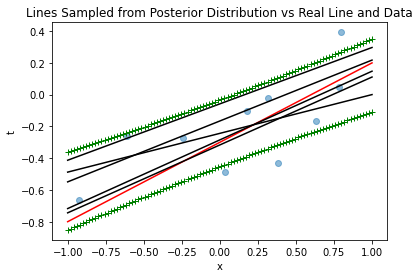

In [17]:
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1], samples=5, stdevs=1)

Let's use the whole data set (1000 points).

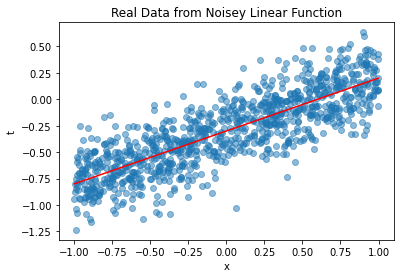

In [18]:
N=1000
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1])

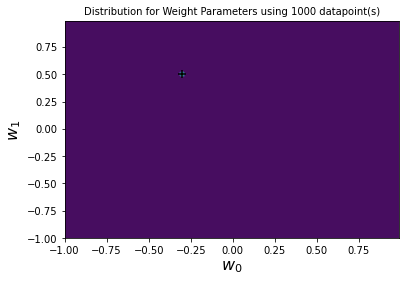

In [19]:
linbayes.set_posterior(x_real[0:N], t_real[0:N])
linbayes.make_contour(x, y, real_parms=[a_0, a_1], N=N)

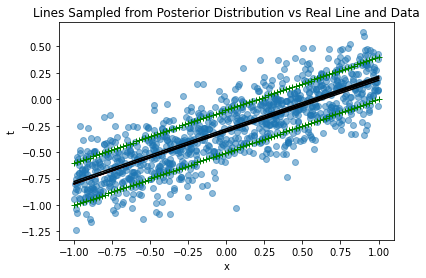

In [20]:
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1], samples=5, stdevs=1)

Note that as the sample size increased, the posterior distribution became much sharper, which expresses greater confidence in the parameter estimates.  When 1000 points were used, sampling from the posterior weights distribution results in lines that are essentially on top of the true line.

However, if we have such strong confidence (as seen by a very sharp posterior distribution) why are our $\pm \sigma_N$ lines so far away still?  All of our sampled lines are so precise and accurate that we can't even *see* the true, red line in the above graph.

This is because there's a limit to our confidence, and that limit is set by the amount of noise in the data.  Let's inspect the predictive distribution's variance given above as $(10.2)$:
$$ \sigma_N^2(\vec{x}) = \frac{1}{\beta} + \vec{\phi}(\vec{x})^T\vec{S}_N\vec{\phi}(\vec{x})$$

There are two terms:  the first is the variance of the gaussian noise intrinsic in the data and the second depends on our posterior's covariance $\vec{S}_N$.  This shows that even if our posterior covariance shrinks to zero, we still have the noise in our data limiting our estimation.  Below we plot our confidence intervals along with $t_{real} \pm \sigma_{noise}$

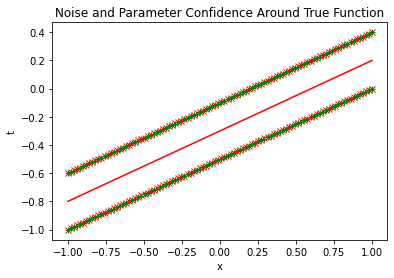

In [21]:
a_x = np.linspace(-1, 1, 100)
plt.plot(a_x, real_function(a_0 + noise_sigma, a_1, 0, a_x), 'x', c='r', linewidth=1.0)
plt.plot(a_x, real_function(a_0 - noise_sigma, a_1, 0, a_x), 'x', c='r', linewidth=1.0)
linbayes.make_scatter([], [], real_parms=[a_0, a_1], stdevs=1)
_ = plt.title('Noise and Parameter Confidence Around True Function')

Note that we have essentially acheived our goal:  we have recovered a probability distribution that not only gives a point estimate of the "true" model, but accounts for noise in both the data and the parameter estimates.

As a final step, let's generate some data from this probability distribution (red) and plot it along real data and the "true" model.

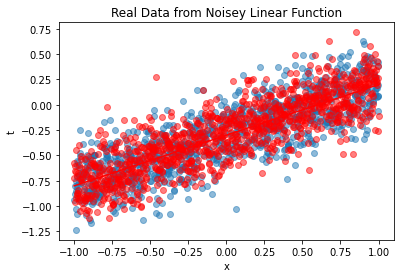

In [22]:
a_x = np.linspace(-1, 1, 1000)
linbayes.make_scatter(x_real[0:N], t_real[0:N], real_parms=[a_0, a_1])
_ = plt.scatter(a_x, linbayes.generate_data(a_x), c='r', alpha=0.5)

## Toy Relevance Vector Machine (Regression) Implementation <a id="rvm"></a>

We consider the following model:
    
\begin{equation*}
    \begin{aligned}
    & p(t_n|x_n, w;\beta) = \mathcal{N}(t_n| \textbf{w}^Tx_n, \beta^{-1}), \\
    & p(\textbf{t}|X,\textbf{w};\beta) = \prod\limits_{n=1}^{N}p(t_n|x_n, \textbf{w};\beta) = \mathcal{N}(\textbf{t}|X\textbf{w}, \beta^{-1}), \\
    & p(\textbf{w};\alpha) = \prod\limits_{d=1}^{D}\mathcal{N}(w_d|0, \alpha_d^{-1})=\mathcal{N}(\textbf{w}|0,A^{-1}).
    \end{aligned}
\end{equation*}  

And for optimize the evidence we come up with the following equations:

$$
\max\limits_{\alpha,\beta}\tfrac{N}{2}\log\beta+\tfrac{1}{2}\log|A|- \tfrac{1}{2}\log|\left(\beta X^TX+A\right)|-\tfrac{\beta}{2}\|\textbf{t}-X\mu\|_2^2 -\tfrac{1}{2}\mu^TA\mu.
$$

\begin{equation*}
\begin{aligned}
& \mu^{new} = \beta(\beta X^T X + A)^{-1}X^T\textbf{t},\\
& \alpha_i^{new} = \frac{1}{\mu^2_i}(1-\Sigma_{ii}^{old}\alpha_i^{old}),\\
& \beta^{new} = \frac{1}{\|t-X\mu\|_2^2}\left(N-\text{trace} (I-\Sigma^{old}A^{old})\right),\\
& \Sigma^{new} = (\beta^{new} X^TX + A^{new})^{-1}.\\
\end{aligned}
\end{equation*}

For details and derivations please see the corresponding slides: [slides](https://drive.google.com/open?id=1ezz6LXef6pFdbljSvvZIlnmYqietQg-s)

##### Task
Please write code at the each method <i>update_%smth%</i>.

In [ ]:
class RVM:
    def __init__(self, data):
        self.X = data[0]
        self.t = data[1]
        
        self.alpha = np.array([0.1] * self.X.shape[1])
        self.beta = 1.
        self.Sigma = None
        
        self.data_cov = None
        self.data_mu = None
        
        self.idx_relevant = np.array(range(self.X.shape[1]))
        
    def data_params(self):
        data_cov = self.X.T @ self.X
        data_mu = self.X.T @ self.t
        return data_cov, data_mu
    
    def get_sigma(self):
        return np.linalg.inv(self.beta * self.data_cov + np.diag(self.alpha))
    
    @staticmethod
    def update_mu(Sigma, beta, data_mu):
        return # write code here
    
    @staticmethod
    def update_alpha(Sigma, beta, mu, alpha):
        # write code here
        return # write code here
    
    @staticmethod
    def update_beta(Sigma, alpha, mu, X, t):
        N = X.shape[0]
        sigma_diag = np.diag(Sigma)
        return # write code here
    
    def update_step(self):
        mu = self.update_mu(self.Sigma, self.beta, self.data_mu)
        alpha = self.update_alpha(self.Sigma, self.beta, mu, self.alpha)
        beta = self.update_beta(self.Sigma, self.alpha, mu, self.X, self.t)
        return mu, alpha, beta
    
    def elbo(self):
        N = self.X.shape[0]
        lbound = N * np.log(self.beta) + np.sum(np.log((self.alpha))) - self.beta * np.linalg.norm(self.X @ self.mu - self.t) ** 2\
        - np.sum(self.mu ** 2 * self.alpha) + np.log(np.linalg.det(self.Sigma))
        return lbound
    
    def prune(self, threshold):
        idx = np.where(self.alpha < threshold)[0]
        if len(idx) != 0:
            bad = np.where(self.alpha >= threshold)[0]
            temp = self.idx_relevant[np.where(self.idx_relevant != -1)] 
            temp[bad] = -1
            self.idx_relevant[np.where(self.idx_relevant != -1)] = temp
            
            self.X = self.X[:, idx]
            self.alpha = self.alpha[idx]
            self.mu = self.mu[idx]
            self.data_cov, self.data_mu = self.data_params()
            
            
    def fit(self, prune=1e5, max_iter=10):
        self.data_cov, self.data_mu = self.data_params()
        
        for i in range(max_iter):
            self.Sigma = self.get_sigma()
            self.mu, self.alpha, self.beta = self.update_step()
            if prune is not None:
                self.prune(prune)
            else:
                self.alpha = np.clip(self.alpha, 0., 1e5)
            print(i, self.elbo())
        return 0
    
    def get_relevant_features_prune(self):
        return self.idx_relevant[np.where(self.idx_relevant != -1)]

Let's see how it works. We generate some sparse data.

In [ ]:
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score

In [ ]:
X, t, coef_true = make_regression(100, 100, 3, coef=True)
print(coef_true)
print(np.where(coef_true != 0)[0])

And now we expect that RVM will return for us exactly these non-zero features.

In [ ]:
reg = RVM((X, t))

In [ ]:
reg.fit(1e5)

In [ ]:
reg.get_relevant_features_prune()

Eeee!